# Book Recommendation System

In [1]:
from IPython.display import SVG
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [3]:
dataset = pd.read_csv('ratings.csv')

In [4]:
dataset.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [5]:
dataset.shape

(981756, 3)

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [7]:
train.head()

,book_id,user_id,rating
341848,3423,4608,2
964349,9811,36373,5
645459,6485,2957,4
74960,750,42400,3
358670,3591,36886,5


In [8]:
test.head()

,book_id,user_id,rating
646451,6495,19643,5
614851,6175,8563,4
974393,9920,52110,3
21471,215,33864,5
272540,2728,16587,3


In [9]:
n_users = len(dataset.user_id.unique())
n_users

53424

In [10]:
n_books = len(dataset.book_id.unique())
n_books

10000

In [11]:
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.compile('adam', 'mean_squared_error')

In [12]:
from keras.models import load_model

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.user_id, train.book_id], train.rating, epochs=10, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [13]:
model.evaluate([test.user_id, test.book_id], test.rating)

196352/196352 [==============================] - 10s 49us/step


0.9767780996897929

In [14]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[4.9226823] 5
[3.977851] 4
[3.987769] 3
[4.864514] 5
[3.5261488] 3
[3.9648943] 3
[3.0488248] 3
[4.6422606] 4
[4.2100654] 3
[4.0156274] 5


[None, None, None, None, None, None, None, None, None, None]

## Visualizing Embeddings

In [15]:
# Extract embeddings
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

In [16]:
book_em_weights[:5]

array([[-1.3115183e-03, -1.7734393e-03,  4.4337083e-02, -3.4495711e-02,
         2.5486518e-02],
       [-9.6206927e-01,  1.4934931e+00,  1.4303006e+00,  1.8805926e+00,
        -1.6482741e+00],
       [-1.3075132e+00,  1.4321817e+00,  7.6743019e-01,  1.6782079e+00,
        -1.6623734e+00],
       [-2.3607635e-01,  1.4192904e+00,  1.4716060e+00,  1.2976843e+00,
        -8.1634808e-01],
       [-1.4984248e+00,  1.5257449e+00,  6.5766782e-01,  1.5735048e+00,
        -1.8767385e+00]], dtype=float32)

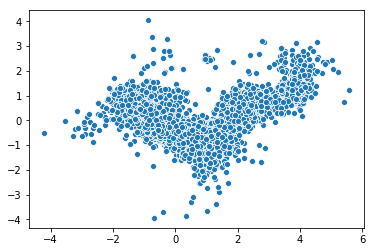

In [17]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [18]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

1.0000001

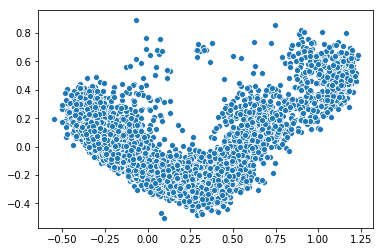

In [19]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.031s...
[t-SNE] Computed neighbors for 10000 samples in 0.908s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.037642
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.276688
[t-SNE] Error after 300 iterations: 2.704514


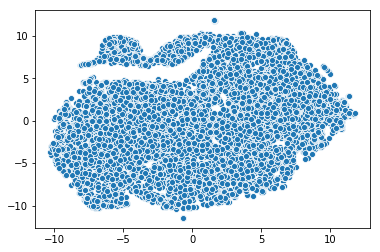

In [21]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making Recommendations

In [29]:
# Creating dataset for making recommendations for the first user
book_data = np.array(list(set(dataset.book_id)))
book_data[:5]

array([1, 2, 3, 4, 5])

In [31]:
user = np.array([1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [50]:
predictions = model.predict([user, book_data])

predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([4942, 7638, 8853, 9079, 9841], dtype=int64)

In [51]:
# print predicted scores
predictions[recommended_book_ids]

array([5.341809 , 5.159592 , 4.9970446, 4.9722786, 4.903894 ],
      dtype=float32)